In [1]:
# Jade Chongsathapornpong, June 2023
import os
import re
from datetime import datetime

import h5py
from larch.io.specfile_reader import DataSourceSpecH5
from larch.plot.plotly_xafsplots import PlotlyFigure

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib nbagg
#%matplotlib inline

# Selecting Data to Plot
The BM23 directory structure is simple, and the files are in an HDF5 format.

In [ ]:
fname = r'..\Data\BM23\WAM46\WAM46_0001\WAM46_0001.h5'
scan_id = 15

t = DataSourceSpecH5(fname)
# t.get_counters()
# t.get_motors()
# t.get_motor_position("kbvo")
t.set_scan(scan_id)
ene = t.get_array("energy_cenc")
mu = t.get_array("mu_fluo")
t._sourcefile[int_to_key(scan_id)]['instrument']['EurothermNanodac']['measure'][()]
fig = PlotlyFigure()
fig.add_plot(ene, mu)
fig.show()

for scaninfo in t.get_scans():
    t.set_scan(scaninfo[0])
    print(t.get_title())

In [18]:
# Modify this block
xn = 'energy_cenc'
yn = 'fluo'
start = 1 # inclusive
end = 10 # not inclusive

# Accessing arrays
times = []
Xs = []
Ys = []

for i in range(start, end):
    k = int_to_key(i)
    Xs.append(f[k]['instrument'][xn]['data'])
    Ys.append(f[k]['instrument'][yn]['data'])

Xs = np.array(Xs)
Ys = np.array(Ys)

array([[7.62303277, 7.62345344, 7.62387416, ..., 8.31852886, 8.31907714,
        8.31961068],
       [7.62298328, 7.62340394, 7.62381229, ..., 8.31838069, 8.31892895,
        8.31947729],
       [7.62302039, 7.62344106, 7.62386178, ..., 8.31835105, 8.31889931,
        8.31943283],
       ...,
       [7.623107  , 7.62354005, 7.62394841, ..., 8.31832142, 8.31888449,
        8.319418  ],
       [7.62306988, 7.62349056, 7.62391128, ..., 8.31824734, 8.3188104 ,
        8.3193439 ],
       [7.62306988, 7.62349056, 7.62391128, ..., 8.31824734, 8.3188104 ,
        8.3193439 ]])

In [5]:
E_edge = 7709 # eV, modify this: Co: 7709 Cu: 8979 Ni: 8333 Zn: 9658 

hbar = 1.055e-34 # J * s
m = 9.1e-31 # kg
JeV = 1.602e-19 # J per eV

def E_to_k(E: np.ndarray, E_edge: float) -> np.ndarray:
    """Args:
        - E (array-like): energies (in eV)
        - E_edge (float): 
    Returns:
        - (array-like) wavenumbers for photoelectron (in 1/A)"""
    K = (E - E_edge) * JeV
    return (np.sqrt(2 * m * K) / hbar) * 1e-10
    
output_data = [] # one element per file consisting of file name, array of energies, array of signals
for file in target_files:
    # Read the temperature logged in the file
    temp = None
    with open(file) as f:
        for i, line in enumerate(f):
            if i == 6: # the temperature is on the 7th line
                temp = float(re.findall(r'\d+.\d+', line)[0])
                break
    # Read the columns
    arr = np.genfromtxt(file).transpose() # 5 rows: shifted energy, normalized signal, reference signal, ref. deriv., I_0
    output_data.append((file, quadratic(temp, poptim[0], poptim[1], poptim[2]), arr[0], E_to_k(arr[0], E_edge), arr[1]))
    # output_data: filename, calib. Temp., energy, wavenumber, XAS signal
                             
# Sort by alphabetical in file name:
output_data.sort(key=lambda x: os.path.split(x[0]))
# or sort by temperature:
# output_data.sort(key=lambda x: x[1])

C:\Users\jade2\AppData\Local\Temp\ipykernel_1144\395661312.py:14: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(2 * m * K) / hbar) * 1e-10


In [6]:
#print(output_data[0])
print("Files:", len(output_data))
print("First 10:\n", [os.path.split(d[0])[-1] for d in output_data[:10]])
print("Last 10:\n", [os.path.split(d[0])[-1] for d in output_data[-10:]])

Files: 195
First 10:
 ['norm_Co_WAM39B_Rampe_1_001_av120_00001.txt', 'norm_Co_WAM39B_Rampe_1_001_av120_00002.txt', 'norm_Co_WAM39B_Rampe_1_001_av120_00003.txt', 'norm_Co_WAM39B_Rampe_1_001_av120_00004.txt', 'norm_Co_WAM39B_Rampe_1_001_av120_00005.txt', 'norm_Co_WAM39B_Rampe_1_002_av120_00001.txt', 'norm_Co_WAM39B_Rampe_1_002_av120_00002.txt', 'norm_Co_WAM39B_Rampe_1_002_av120_00003.txt', 'norm_Co_WAM39B_Rampe_1_002_av120_00004.txt', 'norm_Co_WAM39B_Rampe_1_002_av120_00005.txt']
Last 10:
 ['norm_Co_WAM39B_Rampe_1_038_av120_00001.txt', 'norm_Co_WAM39B_Rampe_1_038_av120_00002.txt', 'norm_Co_WAM39B_Rampe_1_038_av120_00003.txt', 'norm_Co_WAM39B_Rampe_1_038_av120_00004.txt', 'norm_Co_WAM39B_Rampe_1_038_av120_00005.txt', 'norm_Co_WAM39B_Rampe_1_039_av120_00001.txt', 'norm_Co_WAM39B_Rampe_1_039_av120_00002.txt', 'norm_Co_WAM39B_Rampe_1_039_av120_00003.txt', 'norm_Co_WAM39B_Rampe_1_039_av120_00004.txt', 'norm_Co_WAM39B_Rampe_1_039_av120_00005.txt']


# Plots

### Absorption per Temperature

<IPython.core.display.Javascript object>


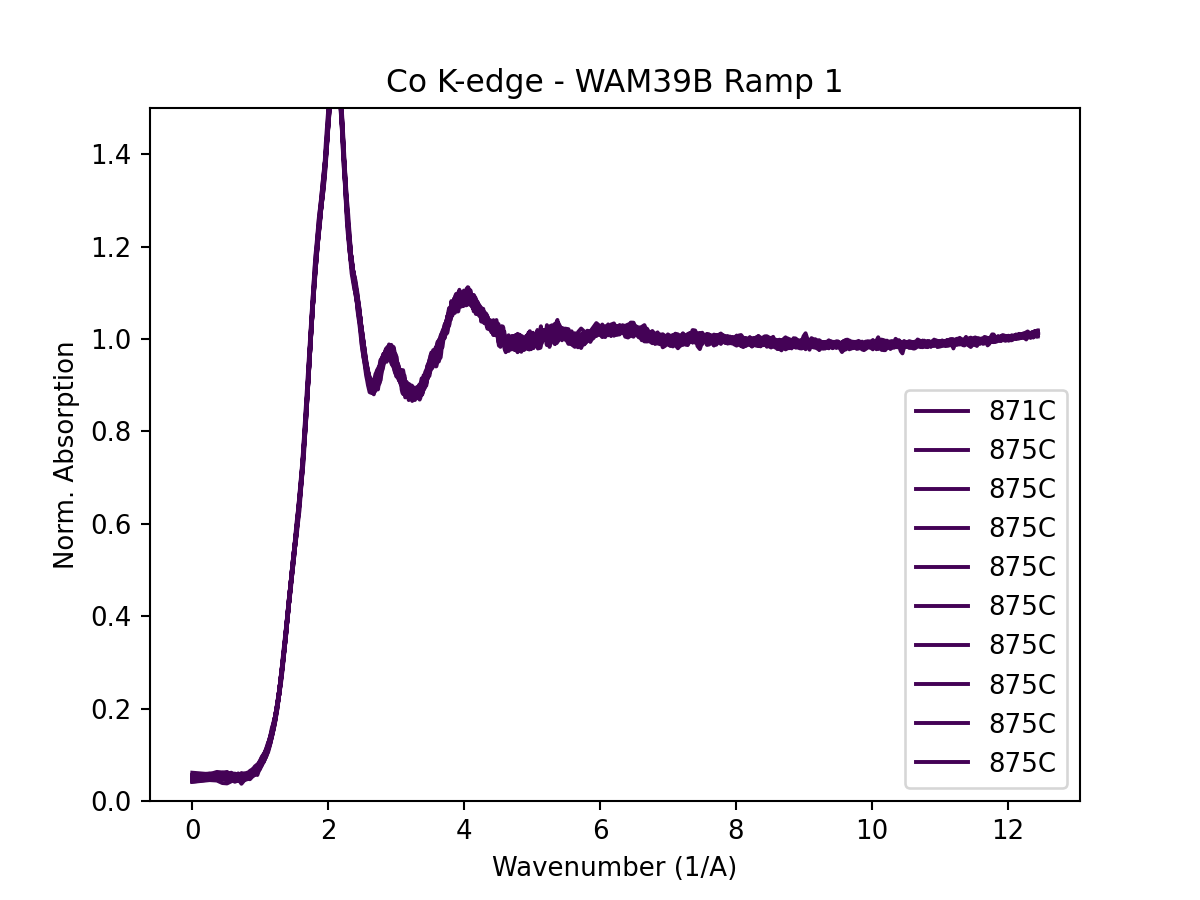

In [7]:
x_axis = 3  # 2 for energy, 3 for k
title = 'Co K-edge - WAM39B Ramp 1'
T_min = 870
T_range = 900
time_per_file = 1 # minutes
stride = 1
label_stride = 5

y_min = 0.0
y_max = 1.5

filtered_data = list(filter(lambda entry: entry[1] > T_min and entry[1] < T_min + T_range, output_data))
plotted_data = []

colors = plt.cm.viridis([(entry[1] - T_min) / T_range for entry in filtered_data])
for i, entry in enumerate(filtered_data):
    if i % stride == 0:
        plt.plot(entry[x_axis], entry[4], label=f'{entry[1]:.0f}C' if i % (stride * label_stride) == 0 else None, color=colors[i])
        plotted_data.append(entry)

plt.title(title)
plt.xlabel(f'Energy (eV)' if x_axis == 2 else 'Wavenumber (1/A)')
plt.ylabel('Norm. Absorption')
plt.ylim((y_min, y_max))
plt.legend()
# plt.savefig(os.path.join('Output', title), dpi=300)
plt.show()

### Comparing individual spectra
This is for comparing, say, the end of a ramp to the end of the subsequent dwell, without the colormap used in the previous cell.

In [ ]:
x_axis = 3  # 2 for energy, 3 for k
title = ' K-edge - WAM39B Ramp 1'

y_min = 0.0
y_max = 1.7

target_filenames = ['End Ramp 1', 'End Plateau 1', 'End Ramp 2', 'End Plateau 2']

for i, entry in enumerate(filtered_data):
        plt.plot(entry[x_axis], entry[4], label=f'{target_filenames[i]}, {entry[1]:.0f}C')

plt.title(title)
plt.xlabel(f'Energy (eV)' if x_axis == 2 else 'Wavenumber (1/A)')
plt.ylabel('Norm. Absorption')
plt.ylim((y_min, y_max))
plt.legend()
# plt.savefig(os.path.join('Output', title), dpi=300)
plt.show()

### Change over Time

In [ ]:
def total_abs_diffs(spectra, wavenumbers=None, wavenumber_window=(2.5, 8)):
    """Args:
        - spectra (2d array-like): list of normalized absorption spectra, in order
        - wavenumbers (array-like): array of the wavenumbers corresponding to points in spectra
        - wavenumber_window (tuple): min, max wavenumber to be accounted in sums
    Returns:
        - (list) total absolute differences between the normalized spectra
            from one to the next within wavenumber_window"""
    ADs = []
    if wavenumbers is not None:
        mask = np.logical_and(wavenumbers > wavenumber_window[0], wavenumbers < wavenumber_window[1])
    else:
        mask = 1
    for i in range(len(spectra) - 1):
        diffs = mask * (spectra[i + 1] - spectra[i])
        ADs.append(np.sum(np.abs(diffs)))
    return ADs

In [ ]:
times = [i * stride * time_per_file for i in range(len(plotted_data) - 1)]
spectra = [entry[4] for entry in plotted_data]
wavenumbers = output_data[0][3]
window = (2.5, 4.6)
abs_diffs = total_abs_diffs(spectra, wavenumbers, window) # taken only from the window !!
temperatures = [entry[1] for entry in plotted_data]

In [ ]:
title2 = "Zn K-edge - WAM39B Ramp 1 - Absolute Differences"

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(times, abs_diffs, color='b')
ax1.set(xticklabels=[])
ax1.set_ylim(0,)
ax1.set_title(title2)
ax1.set_ylabel("Abs. Norm. Difference")
ax2.plot(times, temperatures[1:], color='orange')
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature (C)")

t_onset = 90
T_onset = 610
ax1.axvline(t_onset, color='k', lw=1)
ax2.axvline(t_onset, color='k', lw=1)
ax2.axhline(T_onset, color='k', lw=1, ls='--')

plt.savefig(os.path.join('Output', title2), dpi=300)
plt.show()

some old stuff

In [ ]:
## For printing scan info (optional) (this could use larch.io instead of h5py, but was written before I got larch)
# def int_to_key(i: int) -> str:
#     """To get keys in HDF5 file corresponding to scan indices."""
#     return str(i) + '.1'
# f = h5py.File(fname, 'r')
# for i in range(len(f.keys())):
#     try:
#         k = int_to_key(i+1)
#         x = np.array(f[k]['instrument']['energy_cenc']['data'])
#         T = f[k]['instrument']['EurothermNanodac']['measure'][()]
#         print(f"Scan {k} from {np.min(x)}keV to {np.max(x)}keV at temp {T}")
#     except:
#         print("Scan not readable")